In [1]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import models
import torch

In [18]:
arch = 'resnet32'
dataset = 'cifar10'
loss_type = 'LDAM'
gpu = None
# model_checkpoint = 'checkpoint/cifar10_resnet32_CE_None_exp_0.01_seed_None_0/ckpt.best.pth.tar'
model_checkpoint = 'checkpoint/cifar10_resnet32_LDAM_DRW_exp_0.01_sam_0.8_sched_none_seed_None_0/ckpt.best.pth.tar'

num_classes = 100 if dataset == 'cifar100' else 10
use_norm = True if loss_type == 'LDAM' else False
model = models.__dict__[arch](num_classes=num_classes, use_norm=use_norm)

if gpu is not None:
        torch.cuda.set_device(gpu)
        model = model.cuda(gpu)
else:
    # DataParallel will divide and allocate batch_size to all available GPUs
    model = torch.nn.DataParallel(model).cuda()

checkpoint = torch.load(model_checkpoint)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print(model)


DataParallel(
  (module): ResNet_s(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [19]:

import torchvision.transforms as transforms
import torchvision.datasets as datasets
transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
print('Length of val dataset: ', len(val_dataset))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False,num_workers=12, pin_memory=True)

import torch.nn.functional as F
features = []
labels = []
def get_features():
    def hook(model, input, output):
        features.append(F.avg_pool2d(output, output.size()[3]).view(output.size(0), -1).detach().cpu().numpy())
    return hook


model.module.layer3.register_forward_hook(get_features())

model.eval()
with torch.no_grad():
    for i, (input, target) in enumerate(val_loader):
        labels.extend(target.cpu().numpy())
        if gpu is not None:
            input = input.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        # compute output
        output = model(input)

features = np.concatenate(features, axis=0)
labels = np.array(labels)

Files already downloaded and verified
Length of val dataset:  10000


In [20]:
# high_dim_features = np.random.rand(100, 1000)
high_dim_features = features
high_dim_classes = labels
print(high_dim_features.shape)
print(high_dim_classes.shape)

(10000, 64)
(10000,)


In [21]:

tsne_results = TSNE(n_components=2).fit_transform(high_dim_features,high_dim_classes)
# plt.savefig('/content/tsneflattrain.pdf', bbox_inches='tight')

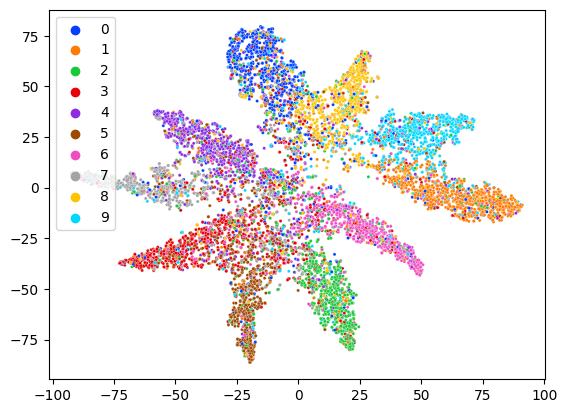

In [22]:
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=high_dim_classes, palette=sns.color_palette("bright", 10), s=5)
plt.show()

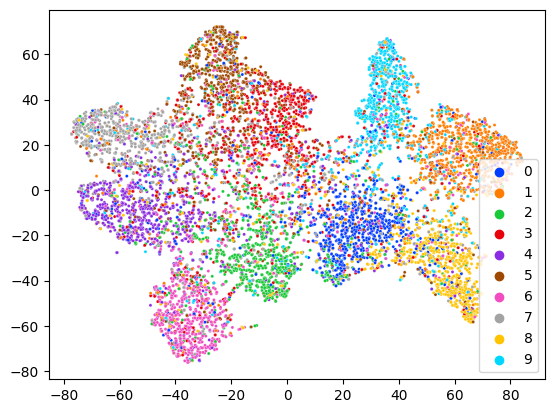

In [6]:
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=high_dim_classes, palette=sns.color_palette("bright", 10), s=5)
plt.show()

In [23]:
# plot scatterpot with selected class colored
import ipywidgets as widgets
dd = widgets.Dropdown(
    options=[str(i) for i in range(10)],
    value='0',
    description='Number:')

def draw_plot(x):
    color = lambda label: 'grey' if label != int(x) else 'red'
    sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=high_dim_classes, palette=[color(i) for i in range(10)], s=5)
    plt.show()

widgets.interactive(draw_plot, x=dd)



interactive(children=(Dropdown(description='Number:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9…